In [1]:
# Spectacle
import spectacle
from spectacle.core.spectra import Spectrum1D
from spectacle.modeling.models import Absorption1D
from spectacle.core.lines import Line
from spectacle.modeling.fitting import LevMarFitter, LevMarLSQFitter, DynamicLevMarFitter

# Misty
import os, sys
sys.path.insert(0, "/Users/nearl/projects/enzo_specs/")
import MISTY

# yt/enzo
import trident
import yt

# general
import numpy as np
import astropy as at
import matplotlib.pyplot as plt

%matplotlib notebook
print(np.__version__, at.__version__)

INFO:root:Added misty to custom loaders.
INFO:root:Added my-format to custom loaders.


('1.13.0', u'1.3.3')


# Trident setup

In [2]:
# Load trident ray data using yt
tri_ray = yt.load("/Users/nearl/Downloads/RD0042_ray_z_imp022.9_ang5.32_tri.h5")
# tri_ray = yt.load("/Users/nearl/Downloads/RD0042_ray_z_imp020.0_ang0.00tri.h5")
# tri_ray = yt.load("/Users/nearl/Downloads/RD0042_ray_z_imp046.4_ang3.23_tri.h5")
# tri_ray = yt.load("/Users/nearl/Downloads/RD0042_ray_z_imp063.8_ang6.07_tri.h5")
# tri_ray = yt.load("/Users/nearl/Downloads/RD0042_ray_z_imp022.9_ang5.32_tri.h5")

# Parse the start/end of ray
ray_start = tri_ray.light_ray_solution[0]['start']
ray_end = tri_ray.light_ray_solution[0]['end']

# Get line information for the line we want
line_name = "Si II 1260"
ldb = trident.LineDatabase('lines.txt')
line_out = ldb.parse_subset(line_name)
line_out = line_out[0]
ar = tri_ray.all_data()

print(line_name, line_out)

# Parse spectrum information from ray
lambda_rest = line_out.wavelength
lambda_min = lambda_rest * (1+min(ar['redshift_eff'])) - 0
lambda_max = lambda_rest * (1+max(ar['redshift_eff'])) + 0
sg = trident.SpectrumGenerator(lambda_min=lambda_min.value, lambda_max=lambda_max.value, dlambda=0.0001)
sg.make_spectrum(tri_ray, lines=line_out.name)

yt : [INFO     ] 2017-06-15 11:30:09,997 Parameters: current_time              = 4.3430653996e+17
yt : [INFO     ] 2017-06-15 11:30:09,998 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-06-15 11:30:09,999 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-06-15 11:30:09,999 Parameters: domain_right_edge         = [  4.43982386e+26   4.43982386e+26   4.43982386e+26]
yt : [INFO     ] 2017-06-15 11:30:10,000 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-06-15 11:30:10,001 Parameters: current_redshift          = 4.4408920985e-16
yt : [INFO     ] 2017-06-15 11:30:10,002 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2017-06-15 11:30:10,002 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2017-06-15 11:30:10,003 Parameters: hubble_constant           = 0.695


('Si II 1260', Si II 1260)

yt : [INFO     ] 2017-06-15 11:30:10,068 Allocating for 1.840e+02 particles (index particle type 'all')
yt : [INFO     ] 2017-06-15 11:30:10,073 Identified 1.770e+02 octs


yt : [INFO     ] 2017-06-15 11:30:10,470 Setting instrument to Custom
yt : [INFO     ] 2017-06-15 11:30:10,474 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2017-06-15 11:30:10,556 Creating spectrum
Adding line - Si II 1260 [1260.422000 A]: : 100%|██████████| 184/184 [00:00<00:00, 2851.43it/s]


# Spectacle setup

In [3]:
# Create Spectrum1D from trident information
disp = np.array(list(sg.lambda_field))
flux = np.array(list(sg.flux_field))
spectrum = Spectrum1D(flux, dispersion=disp)

<IPython.core.display.Javascript object>


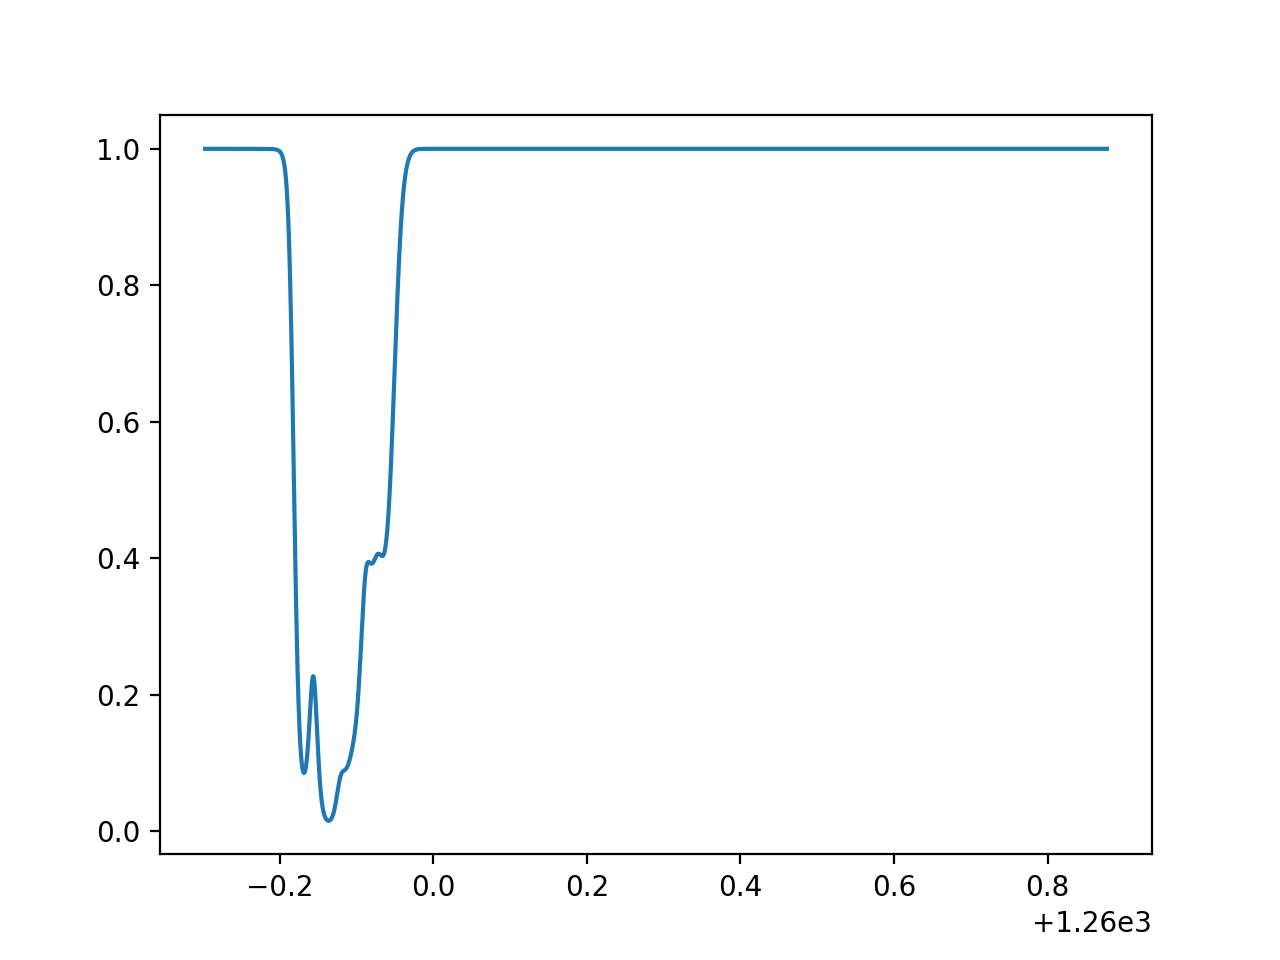

In [4]:
# Plot the trident spectrum
f, ax1 = plt.subplots()

ax1.plot(disp, flux)

In [5]:
# Create Line1D from trident line information
sg_line = sg.line_list[0]

# This process will find lines in the trident spectrum
# and assign the values set in the `defaults` dict to
# the new lines found.
lines = spectrum.find_lines(threshold=0.02/max(1-spectrum.data),
                            min_dist=10,
                            smooth=True,
                            interpolate=True,
                            defaults=dict(
                                lambda_0=sg_line['wavelength'].value,
                                f_value=sg_line['f_value'],
                                gamma=sg_line['gamma'],
                                fixed={
                                    'lambda_0': True,
                                    'delta_v': True,
                                    'delta_lambda': False}
                           ))

# Create absorption Spectrum1D from line information
spec_mod = Absorption1D(lines=lines)

# Create a Spectrum1D object from the Absorption1D model
gen_spec = spec_mod(spectrum.dispersion)

/Users/nearl/anaconda3/envs/spec_env_py27/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
INFO:root:Found 4 lines.
INFO:root:Found SII1260 (1259.519) at 1259.83173004. Strict is False.
INFO:root:Found SII1260_1 (1259.519) at 1259.86373112. Strict is False.
INFO:root:Found SII1260_2 (1259.519) at 1259.919533. Strict is False.
INFO:root:Found SII1260_3 (1259.519) at 1259.93353347. Strict is False.
INFO:root:There are 4 lines in the model.


<IPython.core.display.Javascript object>


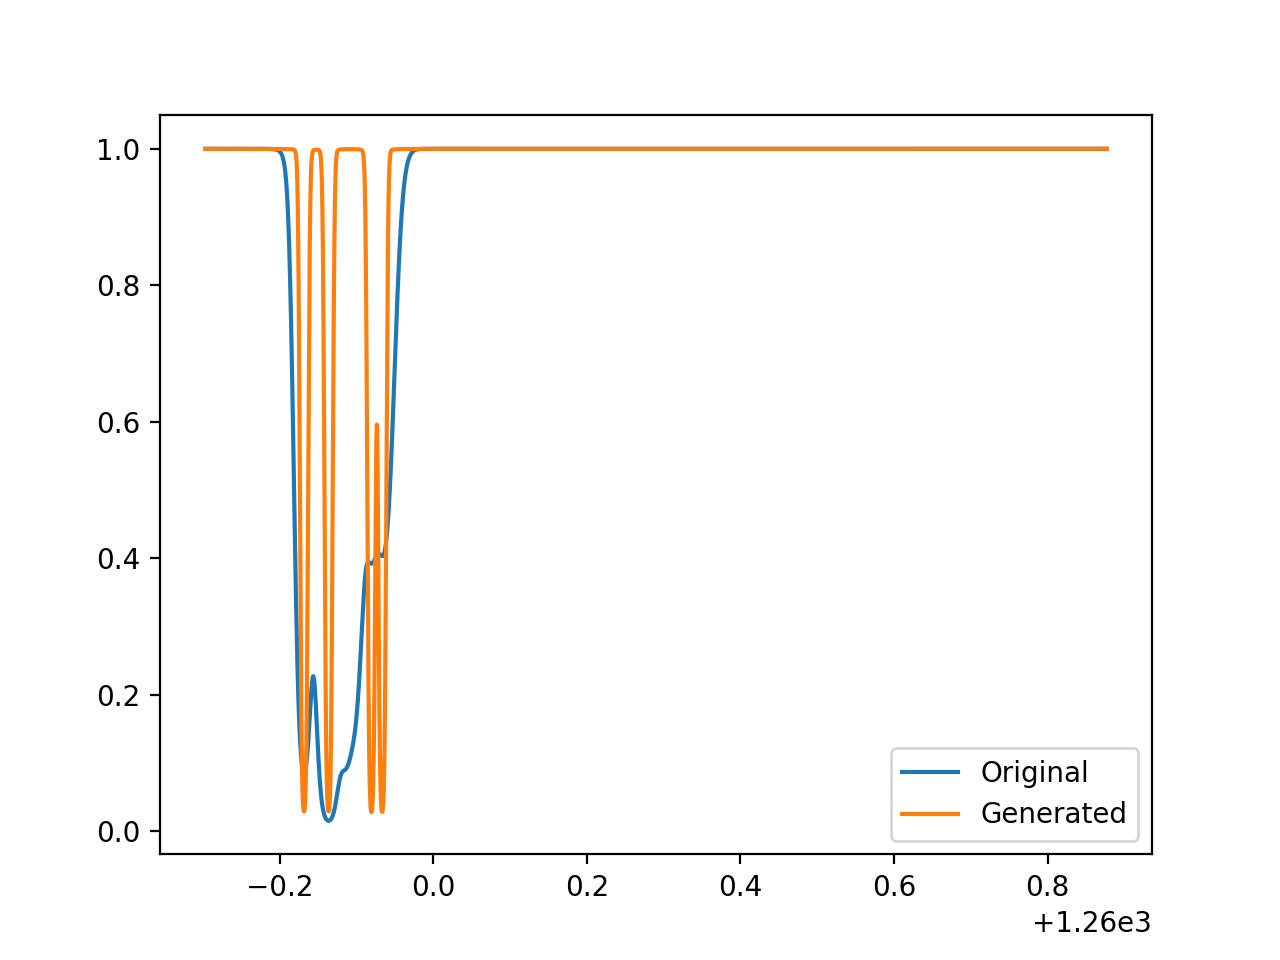

In [6]:
# Plot the generated absorption spectrum
f, ax = plt.subplots()

ax.plot(spectrum.dispersion, spectrum.data, label="Original")
ax.plot(spectrum.dispersion, gen_spec.data, label="Generated")
# ax.set_xlim(1259.63, 1260.78)

plt.legend(loc=0)

In [7]:
# Now fit the generated Spectrum1D object to the ray spectrum data

print(spectrum.dispersion.dtype, spectrum.data.dtype)

# Create a fitter
fitter = DynamicLevMarFitter()

fit_spec_mod = fitter(spec_mod, spectrum.dispersion, spectrum.data,
                      maxiter=1000, initialize=False)

# Get the results of the fit
fit_spec = fit_spec_mod(spectrum.dispersion)

(dtype('float64'), dtype('float64'))
(<type 'numpy.ndarray'>, <type 'numpy.ndarray'>, (11743,), (11743,), <Absorption1D(slope_0=0.0, intercept_0=1.0, lambda_0_1=1260.422, f_value_1=0.188, gamma_1=403000000.0, v_doppler_1=100000.0, column_density_1=13.0, delta_v_1=0.0, delta_lambda_1=-0.5902699615505753, lambda_0_2=1260.422, f_value_2=0.188, gamma_2=403000000.0, v_doppler_2=100000.0, column_density_2=13.0, delta_v_2=0.0, delta_lambda_2=-0.5024670015479842, lambda_0_3=1260.422, f_value_3=0.188, gamma_3=403000000.0, v_doppler_3=100000.0, column_density_3=13.0, delta_v_3=0.0, delta_lambda_3=-0.4884665295658124, lambda_0_4=1260.422, f_value_4=0.188, gamma_4=403000000.0, v_doppler_4=100000.0, column_density_4=13.0, delta_v_4=0.0, delta_lambda_4=-0.5582688827341826)>)


/Users/nearl/anaconda3/envs/spec_env_py27/lib/python2.7/site-packages/astropy/units/quantity.py:957: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__truediv__(other)
/Users/nearl/anaconda3/envs/spec_env_py27/lib/python2.7/site-packages/astropy/units/quantity.py:974: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)
/Users/nearl/projects/spectacle/spectacle/core/profiles.py:90: RuntimeWarning: invalid value encountered in multiply
  return special.wofz(x + 1j * y).real
/Users/nearl/projects/spectacle/spectacle/core/spectra.py:119: RuntimeWarning: invalid value encountered in less
  data[data < 0.0] = 0.0


<class 'abc.Absorption1D'>
Name: Absorption1D (CompoundModel6)
Inputs: (u'x',)
Outputs: (u'y',)
Fittable parameters: (u'slope_0', u'intercept_0', u'lambda_0_1', u'f_value_1', u'gamma_1', u'v_doppler_1', u'column_density_1', u'delta_v_1', u'delta_lambda_1', u'lambda_0_2', u'f_value_2', u'gamma_2', u'v_doppler_2', u'column_density_2', u'delta_v_2', u'delta_lambda_2', u'lambda_0_3', u'f_value_3', u'gamma_3', u'v_doppler_3', u'column_density_3', u'delta_v_3', u'delta_lambda_3')
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Linear1D(slope=-0.00017863503227717392, intercept=1.2250459340111635)>

    [1]: <Line(lambda_0=1260.422, f_value=0.188, gamma=403000000.0, v_doppler=236168.42316842484, column_density=12.932427876350786, delta_v=0.0, delta_lambda=-0.5947541855892857, name='SII1260')>

    [2]: <Line(lambda_0=1260.422, f_value=0.188, gamma=403000000.0, v_doppler=328151.39257707336, column_density=12.84096681756266, delta_v=0.0, delta_lambda=-0.5171873218315843, name='SII1260_2

INFO:root:Fit did not improve by removing line:
	Chi squared: 4.14733070186 -> 10.5883130145.


(<type 'numpy.ndarray'>, <type 'numpy.ndarray'>, (11743,), (11743,), <Absorption1D(slope_0=-0.00017863503227717392, intercept_0=1.2250459340111635, lambda_0_1=1260.422, f_value_1=0.188, gamma_1=403000000.0, v_doppler_1=236168.42316842484, column_density_1=12.932427876350786, delta_v_1=0.0, delta_lambda_1=-0.5947541855892857, lambda_0_2=1260.422, f_value_2=0.188, gamma_2=403000000.0, v_doppler_2=328151.39257707336, column_density_2=12.84096681756266, delta_v_2=0.0, delta_lambda_2=-0.5171873218315843, lambda_0_3=1260.422, f_value_3=0.188, gamma_3=403000000.0, v_doppler_3=400067.5846899007, column_density_3=13.017757483345386, delta_v_3=0.0, delta_lambda_3=-0.48799134634755975, lambda_0_4=1260.422, f_value_4=0.188, gamma_4=403000000.0, v_doppler_4=537345.0209549591, column_density_4=13.719699756407186, delta_v_4=0.0, delta_lambda_4=-0.5555669836979316, lambda_0_5=1260.422, f_value_5=0.188, gamma_5=403000000.0, v_doppler_5=236168.42316842484, column_density_5=12.932427876350786, delta_v_5=

INFO:root:Fit improved with addition of line at 1259.91093271:
	Chi squared: 4.14733070186 -> 0.173949283064.


(<type 'numpy.ndarray'>, <type 'numpy.ndarray'>, (11743,), (11743,), <Absorption1D(slope_0=0.0007932910518308054, intercept_0=7.354613707327109e-07, lambda_0_1=1260.422, f_value_1=0.188, gamma_1=403000000.0, v_doppler_1=246020.76380217233, column_density_1=13.153786004624688, delta_v_1=0.0, delta_lambda_1=-0.5925540245069696, lambda_0_2=1260.422, f_value_2=0.188, gamma_2=403000000.0, v_doppler_2=260766.1207994843, column_density_2=13.081862186222512, delta_v_2=0.0, delta_lambda_2=-0.5266855971716755, lambda_0_3=1260.422, f_value_3=0.188, gamma_3=403000000.0, v_doppler_3=373912.5906229088, column_density_3=12.968748236722384, delta_v_3=0.0, delta_lambda_3=-0.48642696014061615, lambda_0_4=1260.422, f_value_4=0.188, gamma_4=403000000.0, v_doppler_4=359440.29572059406, column_density_4=13.611327397363008, delta_v_4=0.0, delta_lambda_4=-0.5584746558468581, lambda_0_5=1260.422, f_value_5=0.188, gamma_5=403000000.0, v_doppler_5=247327.91263371386, column_density_5=12.546001479445405, delta_v_

INFO:root:Fit improved with addition of line at 1259.81062933:
	Chi squared: 0.173949283064 -> 0.0535647757604.
INFO:root:Fit result is below chi squared of 0.1 (0.0535647757604).


<class 'abc.Absorption1D'>
Name: Absorption1D (CompoundModel17)
Inputs: (u'x',)
Outputs: (u'y',)
Fittable parameters: (u'slope_0', u'intercept_0', u'lambda_0_1', u'f_value_1', u'gamma_1', u'v_doppler_1', u'column_density_1', u'delta_v_1', u'delta_lambda_1', u'lambda_0_2', u'f_value_2', u'gamma_2', u'v_doppler_2', u'column_density_2', u'delta_v_2', u'delta_lambda_2', u'lambda_0_3', u'f_value_3', u'gamma_3', u'v_doppler_3', u'column_density_3', u'delta_v_3', u'delta_lambda_3', u'lambda_0_4', u'f_value_4', u'gamma_4', u'v_doppler_4', u'column_density_4', u'delta_v_4', u'delta_lambda_4', u'lambda_0_5', u'f_value_5', u'gamma_5', u'v_doppler_5', u'column_density_5', u'delta_v_5', u'delta_lambda_5', u'lambda_0_6', u'f_value_6', u'gamma_6', u'v_doppler_6', u'column_density_6', u'delta_v_6', u'delta_lambda_6')
Expression: [0] + [1] + [2] + [3] + [4] + [5] + [6]
Components: 
    [0]: <Linear1D(slope=0.0007932910518308054, intercept=7.354613707327109e-07)>

    [1]: <Line(lambda_0=1260.422, f_val

<IPython.core.display.Javascript object>


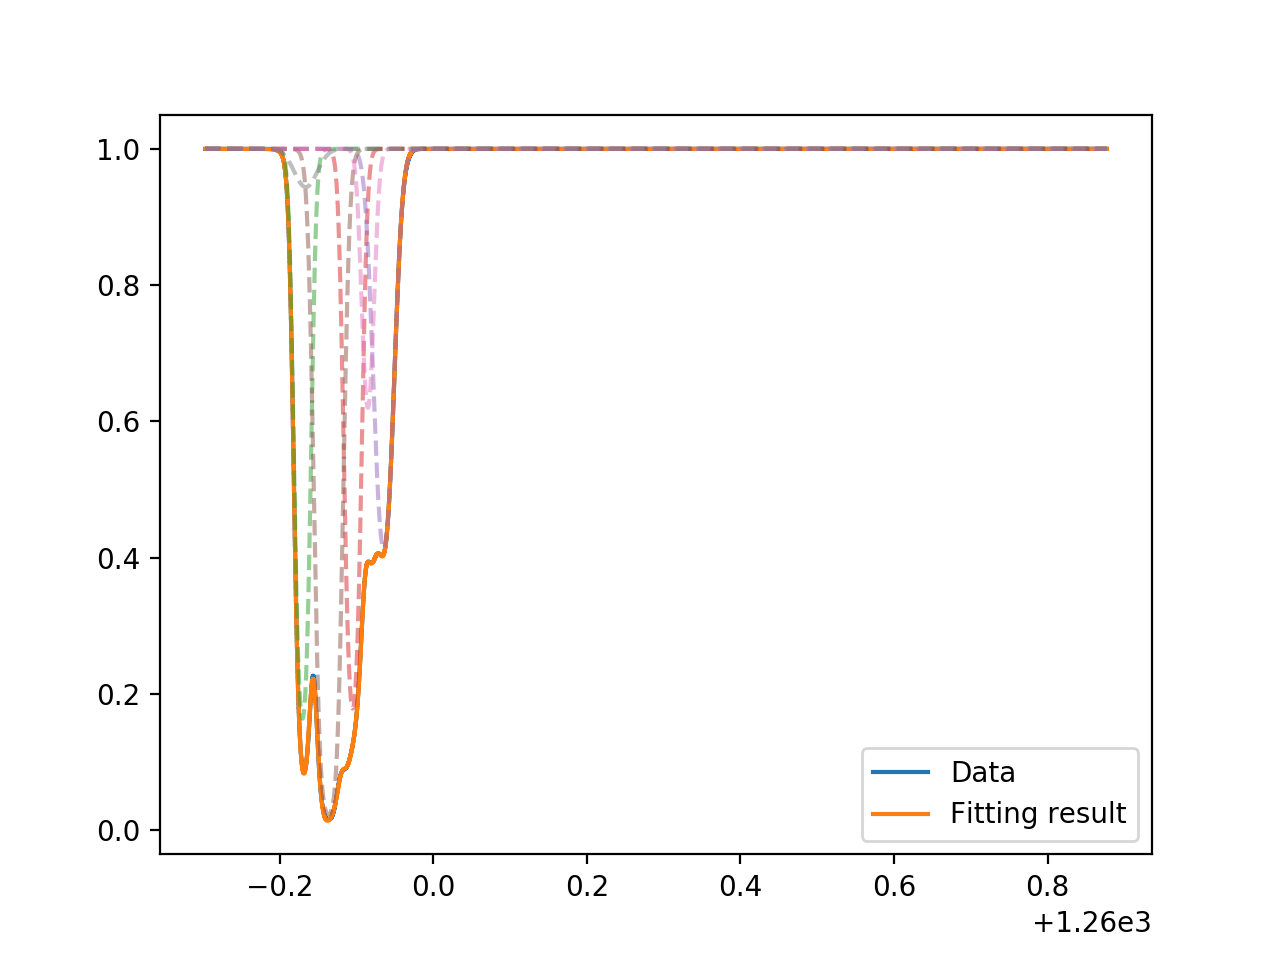

In [8]:
print(type(fit_spec_mod))

# Plot the stacked results
f, (ax1) = plt.subplots()

ax1.step(spectrum.dispersion, spectrum.data, label="Data")
# ax1.step(gen_spec.dispersion, gen_spec.data, label="Initial model")
ax1.step(fit_spec.dispersion, fit_spec.data, label="Fitting result")

for sub_mod in fit_spec_mod[1:]:
    fit_sub_spec = (sub_mod + fit_spec_mod[0])(spectrum.dispersion)
    
    ax1.plot(spectrum.dispersion, fit_sub_spec, linestyle='--', alpha=0.5)

# ax1.set_xlim(1259.7, 1260.26)

plt.legend(loc=0)